In [1]:
!apt-get install graphviz
!pip install graphviz

!mkdir dot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
mkdir: cannot create directory ‘dot’: File exists


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import pandas as pd
from scipy.stats import mode
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import unittest
import math
import random
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor as SKForest
import IPython, graphviz, re
from tqdm import tqdm

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    Source from: https://github.com/fastai/fastai/blob/e6b56de53f80d2b2d39037c82d3a23ce72507cd7/old/fastai/structured.py#L22
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

# Load the data

Data [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [3]:
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv

--2019-10-22 15:19:42--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘house_prices_train.csv.2’

house_prices_train. 100%[===================>] 449.88K  --.-KB/s    in 0.04s   

2019-10-22 15:19:42 (12.3 MB/s) - ‘house_prices_train.csv.2’ saved [460676/460676]

--2019-10-22 15:19:43--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP reques

In [0]:
df_train = pd.read_csv('house_prices_train.csv')
df_test = pd.read_csv('house_prices_test.csv')

In [5]:
df_train.dtypes.sort_values(ascending=False)

HeatingQC        object
CentralAir       object
ExterCond        object
KitchenQual      object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Electrical       object
SaleCondition    object
Neighborhood     object
Heating          object
Exterior2nd      object
MasVnrType       object
BsmtFinType2     object
ExterQual        object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
BsmtQual         object
Functional       object
Condition1       object
FireplaceQu      object
PavedDrive       object
SaleType         object
MSZoning         object
MiscFeature      object
Fence            object
                  ...  
MSSubClass        int64
SalePrice         int64
BsmtFinSF1        int64
BsmtFinSF2        int64
YrSold            int64
MoSold            int64
MiscVal           int64
PoolArea          int64
ScreenPorch       int64
3SsnPorch         int64
EnclosedPorch   

# Data Preprocessing

In [6]:
# Check missing values
def check_missing(df):
  null_val = df.isnull().sum()
  percent = 100 * df.isnull().sum()/len(df)
  missing_table = pd.concat([null_val, percent], axis=1)
  col = missing_table.rename(columns = {0 : '#', 1 : '%'})
  return col

print(f"Missing Data #{str(len(df_train))}")
cols = check_missing(df_train)

print(cols.sort_values(by="%", ascending=False))

Missing Data #1460
                 #          %
PoolQC        1453  99.520548
MiscFeature   1406  96.301370
Alley         1369  93.767123
Fence         1179  80.753425
FireplaceQu    690  47.260274
LotFrontage    259  17.739726
GarageYrBlt     81   5.547945
GarageCond      81   5.547945
GarageType      81   5.547945
GarageFinish    81   5.547945
GarageQual      81   5.547945
BsmtFinType2    38   2.602740
BsmtExposure    38   2.602740
BsmtQual        37   2.534247
BsmtCond        37   2.534247
BsmtFinType1    37   2.534247
MasVnrArea       8   0.547945
MasVnrType       8   0.547945
Electrical       1   0.068493
Id               0   0.000000
Functional       0   0.000000
Fireplaces       0   0.000000
KitchenQual      0   0.000000
KitchenAbvGr     0   0.000000
BedroomAbvGr     0   0.000000
HalfBath         0   0.000000
FullBath         0   0.000000
BsmtHalfBath     0   0.000000
TotRmsAbvGrd     0   0.000000
GarageCars       0   0.000000
...            ...        ...
Condition2       0   

In [7]:
# Check missing values
def check_missing(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    col = missing_table.rename(columns = {0 : '#', 1 : '%'})
    return col

# Display columns missing values are under 1%.
print("Data #"+str(len(df_train)))
cols = check_missing(df_train)
# available_cols = cols[cols['%'] < 1]
# print(available_cols)
print(cols.sort_values(by="%", ascending=False))

Data #1460
                 #          %
PoolQC        1453  99.520548
MiscFeature   1406  96.301370
Alley         1369  93.767123
Fence         1179  80.753425
FireplaceQu    690  47.260274
LotFrontage    259  17.739726
GarageYrBlt     81   5.547945
GarageCond      81   5.547945
GarageType      81   5.547945
GarageFinish    81   5.547945
GarageQual      81   5.547945
BsmtFinType2    38   2.602740
BsmtExposure    38   2.602740
BsmtQual        37   2.534247
BsmtCond        37   2.534247
BsmtFinType1    37   2.534247
MasVnrArea       8   0.547945
MasVnrType       8   0.547945
Electrical       1   0.068493
Id               0   0.000000
Functional       0   0.000000
Fireplaces       0   0.000000
KitchenQual      0   0.000000
KitchenAbvGr     0   0.000000
BedroomAbvGr     0   0.000000
HalfBath         0   0.000000
FullBath         0   0.000000
BsmtHalfBath     0   0.000000
TotRmsAbvGrd     0   0.000000
GarageCars       0   0.000000
...            ...        ...
Condition2       0   0.000000

In [0]:
def handle_missing_data_columns(df):
  df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace = True)

In [0]:
categorical_variables_string = \
    ['MSZoning', 'Street', 'LotShape', 'LandContour', 
     'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
     'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
     'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
     'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 
     'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
     'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 
     'Electrical', 'KitchenQual', 'Functional', 'GarageType', 
     'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 
     'SaleType', 'SaleCondition']

In [0]:
categorical_variables_int = \
  ['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 
   'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
   '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
   'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
   'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
   'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
   'PoolArea', 'MiscVal', 'YrSold']

In [0]:
numerical_variables = \
    ['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 
     'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
     'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
     'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 
     'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
     'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
     'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
     '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']

In [0]:
def fix_categorical_string_data(df):
  for column in categorical_variables_string:
    # Fill NaN with mode
    df[column] = df[column].fillna(df[column].mode()[0])
    # Categorize
    df[column] = pd.factorize(df[column])[0]

In [0]:
def fix_numerical_data(df):
  ss = StandardScaler()
  
  for column in numerical_variables:
      # Fill NaN with mean
      df[column] = df[column].fillna(df[column].mean())
      # Standardize values
      df[column] = ss.fit_transform(df[[column]])

In [0]:
handle_missing_data_columns(df_train)
handle_missing_data_columns(df_test)

In [0]:
fix_categorical_string_data(df_train)
fix_categorical_string_data(df_test)

fix_numerical_data(df_train)
fix_numerical_data(df_test)

# Data exploration

In [16]:
df_train.head(25)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,0.073375,0,-2.293718e-01,-0.207142,0,0,0,0,0,0,0,0,0,0,0,7,5,1.050994,0.878668,0,0,0,0,0,0.511418,0,0,0,0,0,0,0,0.575425,0,-0.288653,-0.944591,-0.459303,0,0,0,0,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,0,0.912210,0,-0.951226,0,1.021157,0,0.311725,0.351000,0,0,0,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2,0.138777,0,0,208500
1,2,-0.872563,0,4.519361e-01,-0.091886,0,0,0,0,1,0,1,1,0,0,1,6,8,0.156734,-0.429577,0,0,1,1,1,-0.574410,1,0,1,0,0,1,1,1.171992,0,-0.288653,-0.641228,0.466465,0,0,0,0,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,1,-0.318683,0,0.600495,0,-0.104483,0,0.311725,-0.060731,0,0,0,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,5,-0.614439,0,0,181500
2,3,0.073375,0,-9.311018e-02,0.073480,0,1,0,0,0,0,0,0,0,0,0,7,5,0.984752,0.830215,0,0,0,0,0,0.323060,0,0,0,0,0,2,0,0.092907,0,-0.288653,-0.301643,-0.313369,0,0,0,0,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,0,-0.318683,0,0.600495,0,0.937776,0,0.311725,0.631726,0,0,0,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,9,0.138777,0,0,223500
3,4,0.309859,0,-4.564744e-01,-0.096897,0,1,0,0,2,0,2,0,0,0,0,7,5,-1.863632,-0.720298,0,0,2,2,1,-0.574410,1,0,2,1,1,0,1,-0.499274,0,-0.288653,-0.061670,-0.687324,0,1,0,0,-0.521734,0.937276,-0.120242,0.383659,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,0,0.296763,0,0.600495,1,0.812705,1,1.650307,0.790804,0,0,0,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,2,-1.367655,0,1,140000
4,5,0.073375,0,6.336182e-01,0.375148,0,1,0,0,1,0,3,0,0,0,0,8,5,0.951632,0.733308,0,0,0,0,0,1.364570,0,0,0,0,0,3,0,0.463568,0,-0.288653,-0.174865,0.199680,0,0,0,0,-0.045611,1.617877,-0.120242,1.299326,1.107810,-0.241061,0.789741,1.227585,1.390023,-0.211454,0,1.527656,0,0.600495,0,0.896086,0,1.650307,1.698485,0,0,0,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,12,0.138777,0,0,250000
5,6,-0.163109,0,6.790387e-01,0.360616,0,1,0,0,0,0,4,0,0,0,2,5,5,0.719786,0.491040,0,0,0,0,1,-0.574410,1,0,3,0,0,0,0,0.632450,0,-0.288653,-1.139286,-0.596115,0,0,0,0,-0.948691,0.501875,-0.120242,-0.292145,1.107810,-0.241061,-1.026041,1.227585,-2.288708,-0.211454,1,-0.934130,0,-0.951226,0,0.604253,1,0.311725,0.032844,0,0,0,-0.432931,-0.251539,-0.359325,10.802446,-0.270208,-0.068692,1.323736,10,0.891994,0,0,143000
6,7,-0.872563,0,2.248335e-01,-0.043379,0,0,0,0,0,0,5,0,0,0,1,8,5,1.084115,0.975575,0,0,0,0,2,0.456019,0,0,0,2,0,3,0,2.029558,0,-0.288653,-0.566519,1.433276,0,0,0,0,1.374993,-0.795163,-0.120242,0.339875,1.107810,-0.241061,0.789741,-0.761621,0.163779,-0.211454,0,0.296763,0,0.600495,0,1.062847,0,0.311725,0.762732,0,0,0,1.283007,0.156111,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,8,-0.614439,0,0,307000
7,8,0.073375,0,6.454645e-16,-0.013513,0,1,0,0,2,0,6,2,0,0,0,7,6,0.057371,-0.574938,0,0,3,3,2,0.755176,1,0,1,0,0,2,1,0.910994,1,-0.090220,-0.795173,0.113032,0,0,0,0,-0.143941,1.457466,-0.120242,1.093729,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,1,0.296763,0,2.152216,0,-0.229554,0,0.311725,0.

In [17]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [18]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,0.073375,0,-0.229372,-0.207142,0,0,0,0,0,0,0,0,0,0,0,7,5,1.050994,0.878668,0,0,0,0,0,0.511418,0,0,0,0,0,0,0,0.575425,0,-0.288653,-0.944591,-0.459303,0,0,0,0,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,0,0.912210,0,-0.951226,0,1.021157,0,0.311725,0.351000,0,0,0,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2,0.138777,0,0,208500
1,2,-0.872563,0,0.451936,-0.091886,0,0,0,0,1,0,1,1,0,0,1,6,8,0.156734,-0.429577,0,0,1,1,1,-0.574410,1,0,1,0,0,1,1,1.171992,0,-0.288653,-0.641228,0.466465,0,0,0,0,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,1,-0.318683,0,0.600495,0,-0.104483,0,0.311725,-0.060731,0,0,0,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,5,-0.614439,0,0,181500
2,3,0.073375,0,-0.093110,0.073480,0,1,0,0,0,0,0,0,0,0,0,7,5,0.984752,0.830215,0,0,0,0,0,0.323060,0,0,0,0,0,2,0,0.092907,0,-0.288653,-0.301643,-0.313369,0,0,0,0,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,0,-0.318683,0,0.600495,0,0.937776,0,0.311725,0.631726,0,0,0,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,9,0.138777,0,0,223500
3,4,0.309859,0,-0.456474,-0.096897,0,1,0,0,2,0,2,0,0,0,0,7,5,-1.863632,-0.720298,0,0,2,2,1,-0.574410,1,0,2,1,1,0,1,-0.499274,0,-0.288653,-0.061670,-0.687324,0,1,0,0,-0.521734,0.937276,-0.120242,0.383659,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,0,0.296763,0,0.600495,1,0.812705,1,1.650307,0.790804,0,0,0,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,2,-1.367655,0,1,140000
4,5,0.073375,0,0.633618,0.375148,0,1,0,0,1,0,3,0,0,0,0,8,5,0.951632,0.733308,0,0,0,0,0,1.364570,0,0,0,0,0,3,0,0.463568,0,-0.288653,-0.174865,0.199680,0,0,0,0,-0.045611,1.617877,-0.120242,1.299326,1.107810,-0.241061,0.789741,1.227585,1.390023,-0.211454,0,1.527656,0,0.600495,0,0.896086,0,1.650307,1.698485,0,0,0,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,12,0.138777,0,0,250000


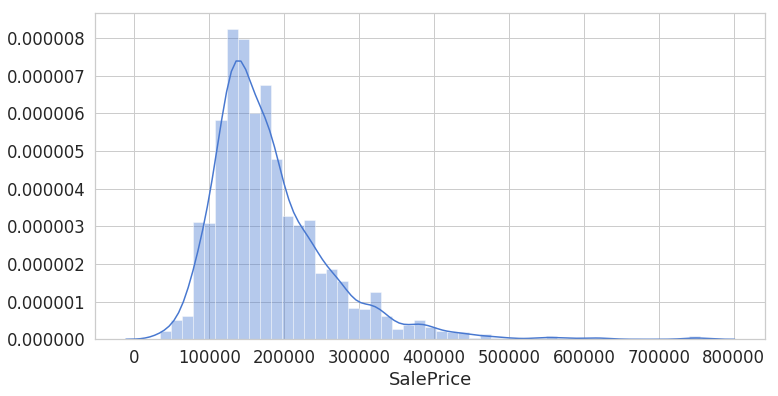

In [19]:
sns.distplot(df_train['SalePrice']);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


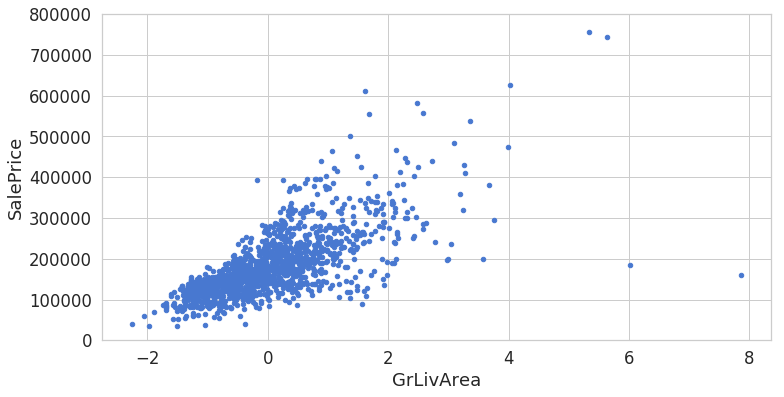

In [20]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


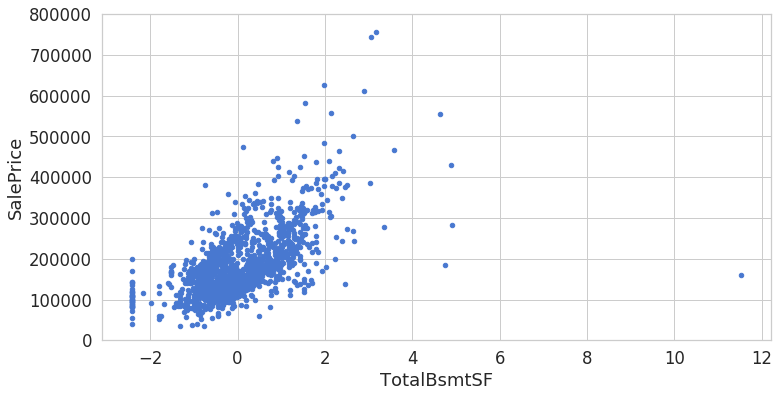

In [21]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

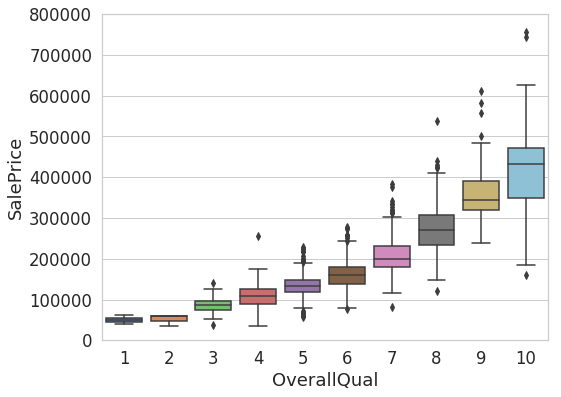

In [22]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

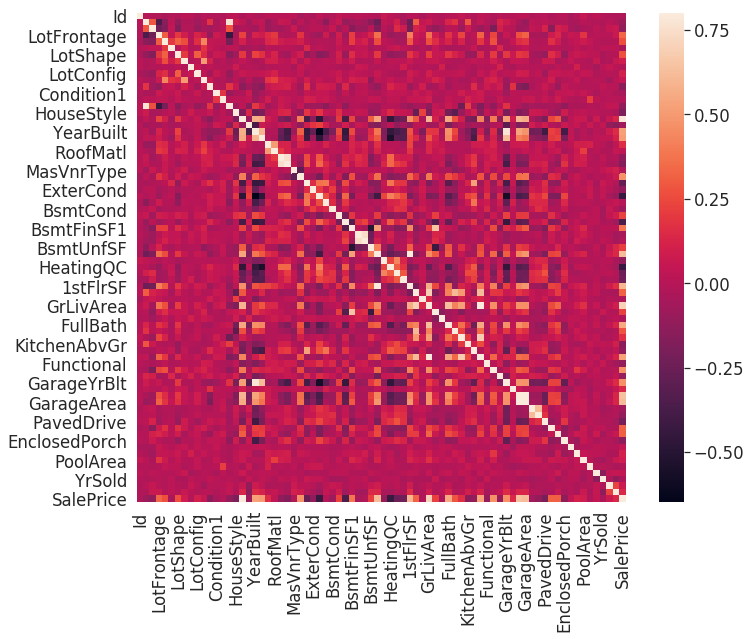

In [23]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

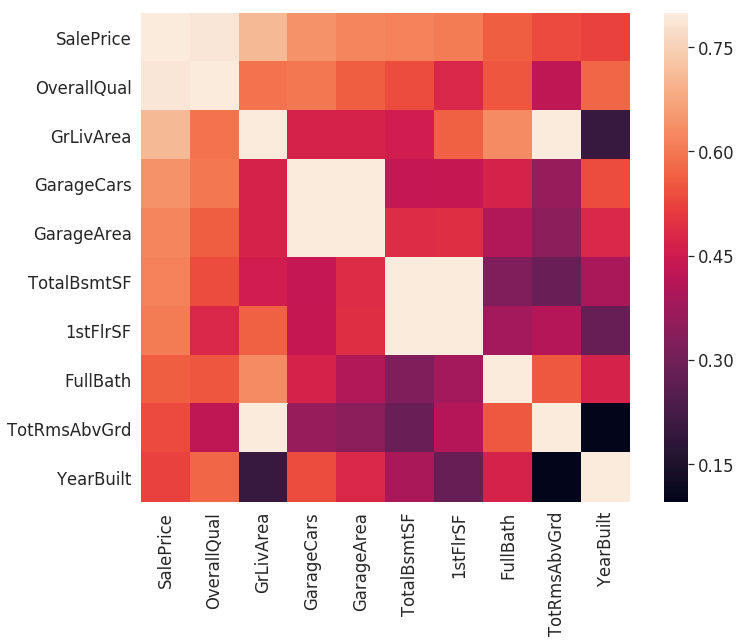

In [24]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_train[cols].corr(), vmax=.8, square=True);

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


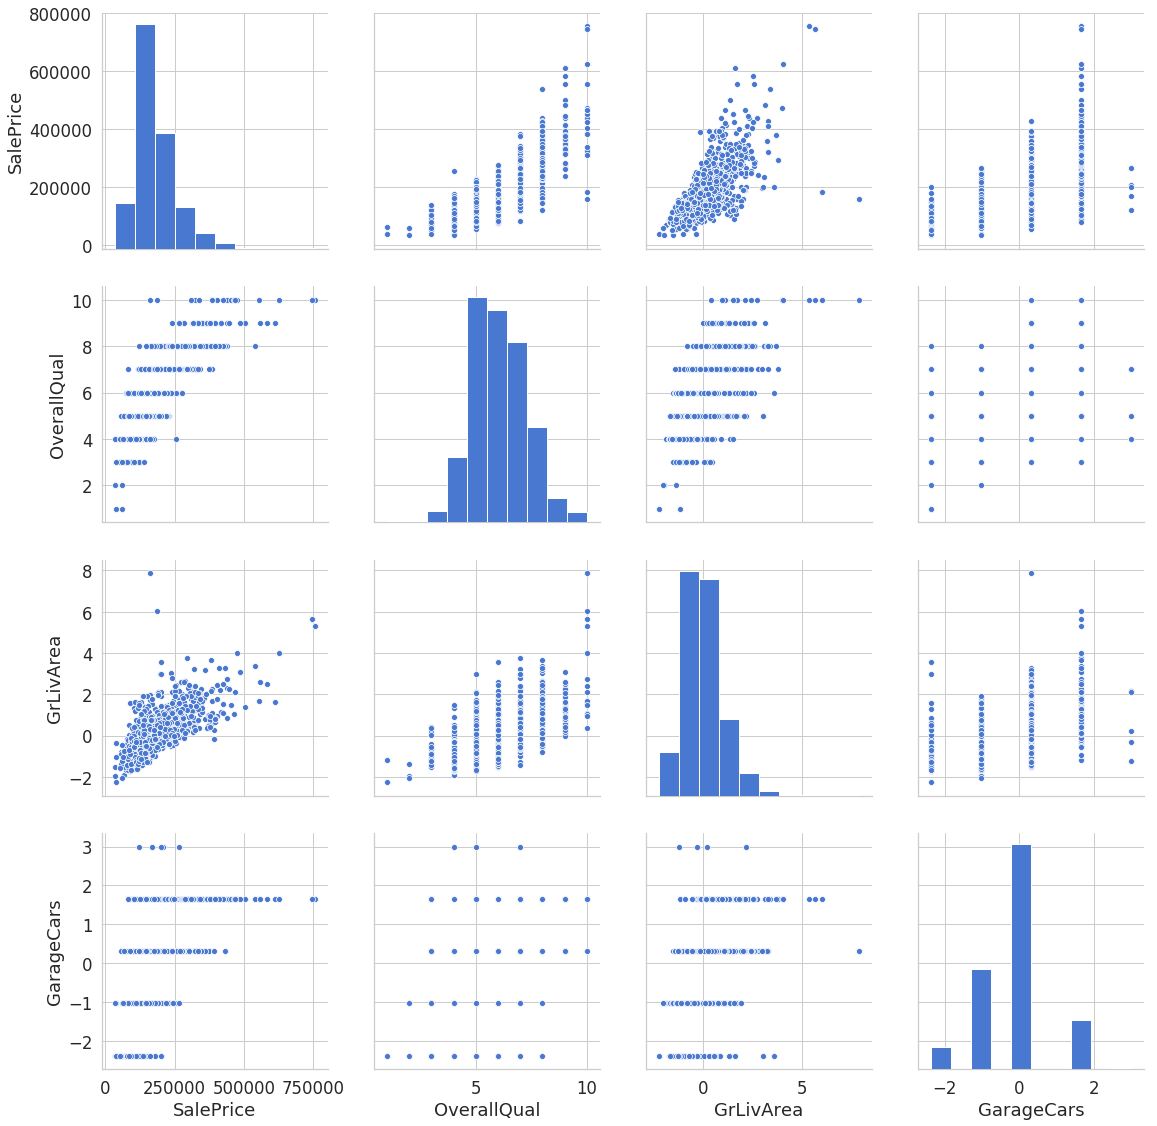

In [25]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']
sns.pairplot(df_train[cols], size = 4);

## Do we have missing data?

In [26]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
SalePrice,0,0.0
ExterCond,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrType,0,0.0
MasVnrArea,0,0.0
ExterQual,0,0.0
Foundation,0,0.0


# Cost function

Root Mean Squared Error:

$$RMSE =  \sqrt{\frac{1}{m} \sum_{i=1}^{m} (y^{(i)} - h(x^{(i)}))^2}$$

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(h, y):
  return sqrt(mean_squared_error(h, y))

# Feature Selection

In [28]:
possible_features = categorical_variables_string + categorical_variables_int + numerical_variables

selector = SelectKBest(f_regression, len(possible_features))
selector.fit(df_train[possible_features], df_train['SalePrice'])
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]

print('Feature importances:')
for i in range(len(scores)):
    print('%.2f %s' % (scores[indices[i]], possible_features[indices[i]]))

Feature importances:
222.35 GrLivArea
222.35 GrLivArea
168.60 GarageCars
168.60 GarageCars
157.28 GarageArea
157.28 GarageArea
151.02 TotalBsmtSF
151.02 TotalBsmtSF
146.27 1stFlrSF
146.27 1stFlrSF
120.91 FullBath
120.91 FullBath
107.56 TotRmsAbvGrd
107.56 TotRmsAbvGrd
102.52 YearBuilt
102.52 YearBuilt
95.50 YearRemodAdd
95.50 YearRemodAdd
82.41 MasVnrArea
82.41 MasVnrArea
80.45 GarageYrBlt
80.45 GarageYrBlt
79.21 Fireplaces
79.21 Fireplaces
65.93 Foundation
65.26 HeatingQC
52.47 BsmtFinSF1
52.47 BsmtFinSF1
45.29 BsmtFinType1
38.87 LotFrontage
38.87 LotFrontage
36.40 WoodDeckSF
36.40 WoodDeckSF
35.24 2ndFlrSF
35.24 2ndFlrSF
34.46 OpenPorchSF
34.46 OpenPorchSF
27.78 HalfBath
27.78 HalfBath
24.67 LotShape
24.16 ExterQual
23.95 LotArea
23.95 LotArea
21.74 CentralAir
18.48 Electrical
18.20 BsmtExposure
17.81 BsmtFullBath
17.81 BsmtFullBath
15.93 BsmtUnfSF
15.93 BsmtUnfSF
15.14 PavedDrive
12.44 HouseStyle
10.00 BedroomAbvGr
10.00 BedroomAbvGr
9.62 Exterior2nd
9.03 RoofStyle
7.45 Neighborhood

In [29]:
features = np.array(possible_features)[scores >= 10]
print(features)

['LotShape' 'HouseStyle' 'ExterQual' 'Foundation' 'BsmtExposure'
 'BsmtFinType1' 'HeatingQC' 'CentralAir' 'Electrical' 'PavedDrive'
 'LotFrontage' 'LotArea' 'YearBuilt' 'YearRemodAdd' 'MasVnrArea'
 'BsmtFinSF1' 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'GrLivArea'
 'BsmtFullBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'TotRmsAbvGrd'
 'Fireplaces' 'GarageYrBlt' 'GarageCars' 'GarageArea' 'WoodDeckSF'
 'OpenPorchSF' 'LotFrontage' 'LotArea' 'YearBuilt' 'YearRemodAdd'
 'MasVnrArea' 'BsmtFinSF1' 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF'
 'GrLivArea' 'BsmtFullBath' 'FullBath' 'HalfBath' 'BedroomAbvGr'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt' 'GarageCars' 'GarageArea'
 'WoodDeckSF' 'OpenPorchSF']


# Model

In [0]:
class Node:

    def __init__(self, x, y, idxs, f_idxs, min_leaf=5, depth=10):
        self.x = x 
        self.y = y
        self.idxs = idxs
        self.f_idxs = f_idxs
        self.min_leaf = min_leaf
        self.depth = depth
        self.row_count = len(idxs)
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        
        self.find_varsplit()
        
    def find_varsplit(self):
        for c in self.f_idxs: self.find_better_split(c)
          
        if self.is_leaf:
          return
        
        x = self.split_col
        
        lhs = np.nonzero(x <= self.split)[0] # lhs indexes
        rhs = np.nonzero(x > self.split)[0] # rhs indexes
        
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.f_idxs, depth=self.depth-1)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.f_idxs, depth=self.depth-1)

    def find_better_split(self, var_idx):
      
        x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]

        for r in range(self.row_count):
            lhs = x <= x[r] # any value in x that is less or equal than this value
            rhs = x > x[r] # any value in x that is greater than this value
            
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf:
              continue
            
            lhs_std = y[lhs].std()
            rhs_std = y[rhs].std()
            
            curr_score = lhs_std * lhs.sum() + rhs_std * rhs.sum() # weighted average
            
            if curr_score < self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]

    @property
    def split_name(self):
      return self.x.columns[self.var_idx]
    
    @property
    def split_col(self):
      return self.x.values[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
      return self.score == float('inf') or self.depth <= 0
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
            
        return s

    def predict(self, x):
        return np.array([self.predict_row(row) for index, row in x.iterrows()])

    def predict_row(self, xi):
        if self.is_leaf:
          return self.val
        
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        
        return t.predict_row(xi)

In [0]:
class DecisionTreeRegressor:
  
  def fit(self, X, y, min_leaf=5, depth=10):
    self.dtree = Node(X, y, np.array(np.arange(len(y))), X.columns, min_leaf, depth)
    return self
  
  def predict(self, X):
    return self.dtree.predict(X.values)    

## Random Forest

In [0]:
class RandomForest:
  
  def fit(self, X, y, predict_fn, n_trees=10, min_leaf=5, depth=10, max_features=None, sample_size=None):
    self._predict_fn = predict_fn
    self._trees = []    
    self._n_features = X.shape[1]

    if max_features == 'sqrt':
        self._n_features = int(np.sqrt(self._n_features))
    elif max_features == 'log2':
        self._n_features = int(np.log2(self._n_features))
    
    rows, cols = X.shape

    if not sample_size:
      sample_size = len(X)
    
    for i in tqdm(range(n_trees)):      
      idxs = np.random.permutation(len(y))[:sample_size]
      f_idxs = np.random.permutation(X.shape[1])[:self._n_features]

      node = Node(X.iloc[idxs], y.values[idxs], idxs=np.array(range(sample_size)), f_idxs=f_idxs, min_leaf=min_leaf, depth=depth)
      self._trees.append(node)
      
    return self
  
  def predict(self, X):
    return self._predict_fn([t.predict(X) for t in tqdm(self._trees)])

## Result Calculation Functions

In [0]:
def majority_vote(X):
  return mode(X, axis=0)

In [0]:
def mean(X):
  return np.mean(X, axis=0)

## Model Usage

In [0]:
X = df_train[features]
y = df_train['SalePrice']

In [0]:
# validation_pivot = int(0.8 * len(y))

# X_train = X[:validation_pivot]
# y_train = y[:validation_pivot]

# X_val = X[validation_pivot:]
# y_val = y[validation_pivot:]

In [43]:
forest_regressor = RandomForest().fit(X, y.to_frame(), predict_fn=mean, n_trees=50, min_leaf=2, max_features='log2', depth=14)


100%|██████████| 50/50 [03:54<00:00,  4.81s/it]


In [44]:
forest_train_predictions = forest_regressor.predict(X)


100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


In [47]:
sk_regressor = SKForest(n_estimators=50, max_depth=14, min_samples_leaf=2, max_features='log2', bootstrap=False, random_state=RANDOM_SEED)
sk_regressor.fit(X, y.to_frame())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=14,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
sk_train_predictions = sk_regressor.predict(X)

## Evaluation

In [49]:
print(f"Custom Forest: { str(metrics.r2_score(y, forest_train_predictions)) }")
print(f"SK Forest: { str(metrics.r2_score(y, sk_train_predictions)) }")

Custom Forest: 0.9130323560719935
SK Forest: 0.991191441020789


In [50]:
print(f"Custom Forest: Train Set: { str(rmse(y, forest_train_predictions)) }")
print(f"SK Forest: Train Set: { str(rmse(y, sk_train_predictions)) }")

Custom Forest: Train Set: 23419.789581033245
SK Forest: Train Set: 7453.43673907973


# Sending to Kaggle

In [0]:
pred_test = forest_regressor.predict(df_test[features])

In [0]:
submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': pred_test})

In [0]:
submission.to_csv('submission.csv', index=False)

In [0]:
from google.colab import files
files.download('submission.csv')

# Resources

[Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)